In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook
import seaborn as sns
import imageio
import time
from IPython.display import HTML
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder

In [ ]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["red","yellow","blue"])

In [ ]:
np.random.seed(0)

#Vectorization Test

In [ ]:
N = 100
M = 400
a = np.random.randn(N,M)
b = np.random.randn(N,M)
c = np.zeros((N,M))

In [ ]:
%%time

for i in range(N):
  for j in range(M):
    c[i,j] = a[i,j] + b[i,j]

CPU times: user 34.5 ms, sys: 954 µs, total: 35.4 ms
Wall time: 37.6 ms


In [ ]:
%%time

c = a + b

CPU times: user 629 µs, sys: 86 µs, total: 715 µs
Wall time: 469 µs


In [ ]:
%%time

for i in range(N):
  for j in range(M):
    c[i,j] = np.sin(a[i,j])

CPU times: user 73.1 ms, sys: 0 ns, total: 73.1 ms
Wall time: 73.2 ms


In [ ]:
%%time
c = np.sin(a)

CPU times: user 1.16 ms, sys: 909 µs, total: 2.07 ms
Wall time: 1.73 ms


#FFNN


In [ ]:
data, labels = make_blobs(n_samples = 1000, centers=4, n_features = 2, random_state = 0)
print(data.shape,labels.shape)

(1000, 2) (1000,)


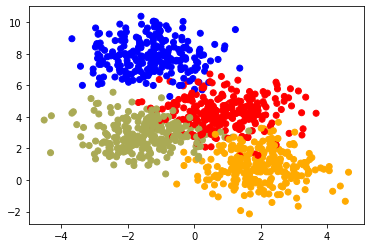

In [ ]:
plt.scatter(data[:,0], data[:,1], c = labels, cmap = my_cmap)

In [ ]:
labels_ori = labels
labels = np.mod(labels_ori, 2)

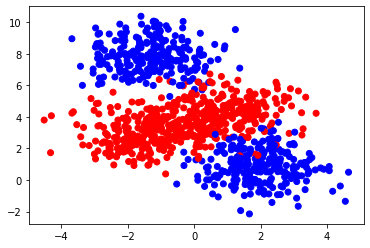

In [ ]:
plt.scatter(data[:,0], data[:,1], c = labels, cmap = my_cmap)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(data,labels, stratify = labels, random_state = 0)
print(X_train.shape,X_val.shape,labels_ori.shape)

(750, 2) (250, 2) (1000,)


In [ ]:
enc = OneHotEncoder()
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
Y_OH_test = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(Y_OH_train.shape,Y_OH_test.shape)

(750, 4) (250, 4)


In [ ]:
print(Y_OH_test[:4])

[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


In [ ]:
a = np.array([1,2])
b = np.array([[2,5,3],
             [2,-1,4]])

In [ ]:
print(np.matmul(a,b))

[ 6  3 11]


In [ ]:
W1 = np.random.randn(2,2)
W2 = np.random.randn(2,4)

In [ ]:
class FFNNVector:

  def __init__(self, W1, W2):
    self.W1 = W1.copy()
    self.W2 = W2.copy()
    self.B1 = np.zeros((1,2))
    self.B2 = np.zeros((1,4))

  def sigmoid(self, x):
    return 1.0 / (1.0 + np.exp(-x))

  def softmax(self, x):
    exps = np.exp(x)
    return exps/np.sum(exps)

  def forwardpass(self, x):
    x = x.reshape(1,-1)
    self.A1 = np.matmul(x,self.W1) + self.B1
    self.H1 = self.sigmoid(self.A1)
    self.A2 = np.matmul(self.H1,self.W2) + self.B2
    self.H2 = self.softmax(self.A2)
    return self.H2

  def sig_grad(self,x):
    return x*(1-x)

  def grad(self,x,y):
    self.forwardpass(x)
    x = x.reshape(1,-1) #(1,2)
    y = y.reshape(1,-1) #(1,4)

    self.DA2 = self.H2 - y #(1,4)
    self.DW2 = np.matmul(self.H1.T, self.DA2) #(2,1) * (1,4) -> (2,4)
    self.DB2 = self.DA2 #(1,4)
    self.DH1 = np.matmul(self.DA2, self.DW2.T) #(1,4) * (4,2) ->(1,2)
    self.DA1 = np.multiply(self.DH1,self.sig_grad(self.H1)) # (1,2)
    self.DW1 = np.matmul(x.T,self.DA1) #(2,1) * (1,2) -> (2,2)
    self.DB1 = self.DA1 #(1,2)

  def fit(self, X, Y, epochs = 1000, learning_rate = 1, display_loss = False):
    if display_loss:
        loss = {}  

    for i in tqdm_notebook(range(epochs), total = epochs, unit = 'epochs'):
      
      
      DW1 = np.zeros((2,2))
      DW2 = np.zeros((2,4))
      DB1 = np.zeros((1,2))
      DB2 = np.zeros((1,4))

      for x,y in zip(X,Y):

        self.grad(x,y)
        DW1 += self.DW1
        DW2 += self.DW2 
        DB1 += self.DB1 
        DB2 += self.DB2 

      m = X.shape[0]
      self.W2 -= learning_rate * (DW2/m)
      self.B2 -= learning_rate * (DB2/m)
      self.W1 -= learning_rate * (DW1/m)
      self.B1 -= learning_rate * (DB1/m)

      if display_loss:
        Y_pred = self.predict(X)
        loss[i] = log_loss(np.argmax(Y, axis=1), Y_pred)
        prev_loss = loss[i]
    
    if display_loss:
      plt.plot(list(loss.values()))
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.show()


  def predict(self,X):

    Y_pred = []
    for x in X:
      y_pred = self.forwardpass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()

In [ ]:
FFNN = FFNNVector(W1,W2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2000 [00:00<?, ?epochs/s]

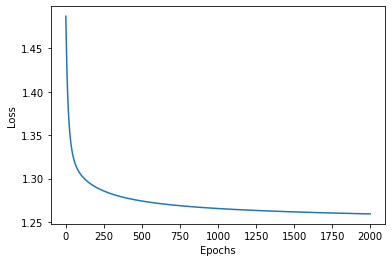

CPU times: user 1min 16s, sys: 430 ms, total: 1min 16s
Wall time: 1min 17s


In [ ]:
%%time
FFNN.fit(X_train, Y_OH_train, epochs=2000, learning_rate=0.5, display_loss=True)

In [ ]:
class FF_MultiClass_InputWeightVectorised:
  
  def __init__(self, W1, W2):
    self.W1 = W1.copy()
    self.W2 = W2.copy()
    self.B1 = np.zeros((1,2))
    self.B2 = np.zeros((1,4))
  
  def sigmoid(self, X):
    return 1.0/(1.0 + np.exp(-X))
  
  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
  
  def forward_pass(self, X):
    self.A1 = np.matmul(X,self.W1) + self.B1 # (N, 2) * (2, 2) -> (N, 2)
    self.H1 = self.sigmoid(self.A1) # (N, 2)
    self.A2 = np.matmul(self.H1, self.W2) + self.B2 # (N, 2) * (2, 4) -> (N, 4)
    self.H2 = self.softmax(self.A2) # (N, 4)
    return self.H2
    
  def grad_sigmoid(self, X):
    return X*(1-X) 
  
  def grad(self, X, Y):
    self.forward_pass(X)
    m = X.shape[0]
    
    self.dA2 = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
    
    self.dW2 = np.matmul(self.H1.T, self.dA2) # (2, N) * (N, 4) -> (2, 4)
    self.dB2 = np.sum(self.dA2, axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.dH1 = np.matmul(self.dA2, self.W2.T) # (N, 4) * (4, 2) -> (N, 2)
    self.dA1 = np.multiply(self.dH1, self.grad_sigmoid(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    
    self.dW1 = np.matmul(X.T, self.dA1) # (2, N) * (N, 2) -> (2, 2)
    self.dB1 = np.sum(self.dA1, axis=0).reshape(1, -1) # (N, 2) -> (1, 2)

      
  def fit(self, X, Y, epochs=1, learning_rate=1, display_loss=False):
      
    if display_loss:
      loss = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      self.grad(X, Y) # X -> (N, 2), Y -> (N, 4)
        
      m = X.shape[0]
      self.W2 -= learning_rate * (self.dW2/m)
      self.B2 -= learning_rate * (self.dB2/m)
      self.W1 -= learning_rate * (self.dW1/m)
      self.B1 -= learning_rate * (self.dB1/m)

      if display_loss:
        Y_pred = self.predict(X)
        loss[i] = log_loss(np.argmax(Y, axis=1), Y_pred)
    
    
    if display_loss:
      plt.plot(list(loss.values()))
      plt.xlabel('Epochs')
      plt.ylabel('Log Loss')
      plt.show()
      
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()

In [ ]:
FFNN3 = FF_MultiClass_InputWeightVectorised(W1,W2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2000 [00:00<?, ?epoch/s]

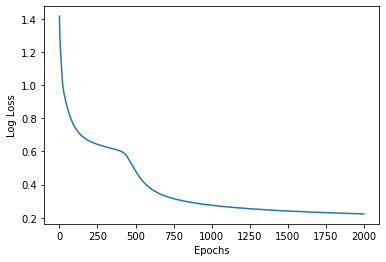

CPU times: user 2.75 s, sys: 25 ms, total: 2.78 s
Wall time: 2.82 s


In [ ]:
%%time
FFNN3.fit(X_train, Y_OH_train, epochs=2000, learning_rate=0.5, display_loss=True)